# Building an AWS Solution Architect Agent with Generative AI

This notebook walks through  building an AI-powered Solution Architect Agent dubbed "Agent AWS" using HuggingFace Transformers and AWS Sagemaker.

The three tools for Agent AWS are:

1. **AWS Well-Architected Framework Query Tool**: This tool will allow your agent to interact directly with the AWS Well-Architected Framework, extracting valuable data to inform architectural decisions.
2. **Code Generation Tool:** This tool will generate code from AWS CloudFormation scripts to Java code.
3. **Diagram Creation Tool:** This tool will create AWS diagrams.

## Agent AWS

**Agent AWS** is an automated, AI-powered agent that uses HuggingFace Transformers paired with numerous different foundation models. 

An “agent” here is a large language model (LLM) equipped with a prompt and access to a specific set of tools. Tools are self-contained functions that perform a singular task that the agent can use when given an instruction.

Agent AWS contains a set of tools that allows it to query AWS documentation, generating code, and creating architectural diagrams.

In [1]:
import json
import os
import subprocess
from typing import Dict

import requests
from langchain import PromptTemplate, SagemakerEndpoint
from langchain.chains.question_answering import load_qa_chain
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms.sagemaker_endpoint import LLMContentHandler
from langchain.prompts.prompt import PromptTemplate
from langchain.vectorstores import FAISS
from PIL import Image
from transformers import Tool
from transformers.tools import HfAgent

os.environ["TOKENIZERS_PARALLELISM"] = "false"
# Learn how to get your own free key here https://huggingface.co/docs/hub/security-tokens
HUGGING_FACE_KEY = os.environ["HUGGING_FACE_KEY"]

## Agent Prompt

The language model powering the agent is conditioned on a long prompt that the user provides. Using that prompt the model is able to generate words to complete the user’s request. 

The prompt is structured broadly into two parts.

1. Role: How the agent should behave, explanation of the concept of tools.
2. Examples of tasks and their solution


In [2]:
sa_prompt = """
You are an expert AWS Certified Solutions Architect. Your role is to help customers understand best practices on building on AWS. You will generate Python commands using available tools to help will customers solve their problem effectively.
To assist you, you have access to three tools. Each tool has a description that explains its functionality, the inputs it takes, and the outputs it provides.
First, you should explain which tool you'll use to perform the task and why. Then, you'll generate Python code. Python instructions should be simple assignment operations. You can print intermediate results if it's beneficial.

Tools:
<<all_tools>>

Task: "Help customers understand best practices on building on AWS by using relevant context from the AWS Well-Architected Framework."

I will use the AWS Well-Architected Framework Query Tool because it provides direct access to AWS Well-Architected Framework to extract information.

Answer:
```py
response = well_architected_tool(query="How can I design secure VPCs?")
print(f"{response}.")
```

Task: "Write a function in Python to upload a file to Amazon S3"

I will use the Code Generation Tool because it can generate code based on the provided requirements.

Answer:
```py

python_code = code_generation_tool(prompt="Write a function in Python to upload a file to Amazon S3")
print(f"{python_code}")
```

Task: "Create a diagram for the following architecture: three EC2 instances connected to an S3 bucket and a RDS database."

I will use the Diagram Creation Tool because it can create insightful diagrams to represent the given AWS architecture.

Answer:

```py
architecture_diagram = diagram_creation_tool(query="Three EC2 instances connected to an S3 bucket and a RDS database.")
```


Task: "<<prompt>>"

I will use the following
"""

## Tools

Now that we have defined our agent prompt, the next step is to create the tools for the agent to use. Tools are very simple: they’re a single function, with a name, and a description. The descriptions are used to prompt the agent to complete tasks. 

### AWS Well-Architected Framework Query Tool
This tool will allow your agent to interact directly with the AWS Well-Architected Framework, extracting valuable data to inform architectural decisions.

This notebook is using the AI21 Jurassic-2 Grande instruct foundation model provided by Amazon SageMaker JumpStart.
You will need to deploy your own model or input a different model. Use this notebook as a template of what can be built

Resources:
1. https://aws.amazon.com/sagemaker/jumpstart/
2. https://aws.amazon.com/blogs/machine-learning/ai21-jurassic-1-foundation-model-is-now-available-on-amazon-sagemaker/

In [3]:
class AWSWellArchTool(Tool):
    name = "well_architected_tool"
    description = "Use this tool for any AWS related question to help customers understand best practices on building on AWS. It will use the relevant context from the AWS Well-Architected Framework to answer the customer's query. The input is the customer's question. The tool returns an answer for the customer using the relevant context."
    inputs = ["text"]
    outputs = ["text"]

    def qa_chain(self):
        prompt_template = """Use the following pieces of context to answer the question at the end.

        {context}

        Question: {question}
        Answer:"""
        PROMPT = PromptTemplate(
            template=prompt_template, input_variables=["context", "question"]
        )

        class ContentHandler(LLMContentHandler):
            content_type = "application/json"
            accepts = "application/json"

            def transform_input(self, prompt: str, model_kwargs: Dict) -> bytes:
                # clean prompt
                prompt = prompt.replace("\\n,", "").replace("\n", "").strip()

                payload = {
                    "prompt": prompt,
                    "maxTokens": 2048,
                    "temperature": 0.7,
                    "numResults": 1,
                }

                payload = json.dumps(payload).encode("utf-8")
                return payload

            def transform_output(self, output: bytes) -> str:
                response_json = json.loads(output.read().decode("utf-8"))
                return response_json["completions"][0]["data"]["text"]

        content_handler = ContentHandler()
        # Setup chain
        chain = load_qa_chain(
            llm=SagemakerEndpoint(
                endpoint_name="j2-grande-instruct",
                region_name="us-east-1",
                credentials_profile_name="default", 
                content_handler=content_handler,
            ),
            prompt=PROMPT,
        )

        return chain

    def __call__(self, query):
        chain = self.qa_chain()
        # Find docs
        embeddings = HuggingFaceEmbeddings()
        vectorstore = FAISS.load_local("local_index", embeddings)
        docs = vectorstore.similarity_search(query)

        doc_sources_string = ""
        for doc in docs:
            doc_sources_string += doc.metadata["source"] + "\n"

        results = chain(
            {"input_documents": docs, "question": query}, return_only_outputs=True
        )

        resp_json = {"ans": str(results["output_text"]), "docs": doc_sources_string}

        return resp_json

In [4]:
#### Using the Tool
query = "How can I design secure VPCs?"
well_arch_tool = AWSWellArchTool()
well_arch_tool(query)

{'ans': ' VPCs can be designed securely by applying multiple controls with a defense in depth approach. This includes the use of security groups (stateful inspection firewall), Network ACLs, subnets, and route tables, as well as making VPCs as large as possible.',
 'docs': 'https://docs.aws.amazon.com/wellarchitected/latest/security-pillar/sec_network_protection_layered.html\nhttps://docs.aws.amazon.com/wellarchitected/latest/framework/sec_network_protection_layered.html\nhttps://docs.aws.amazon.com/wellarchitected/latest/framework/rel_planning_network_topology_ip_subnet_allocation.html\nhttps://docs.aws.amazon.com/wellarchitected/latest/reliability-pillar/rel_planning_network_topology_ip_subnet_allocation.html\n'}

### Code Generation Tool
This tool will generate code from AWS CloudFormation scripts to Python code.

This notebook is using the Starcoder hosted on HuggingFace.

**You need to have your own API key to use this.** You are free to swap in other models as well.
Remember use this notebook as a guide to inspire in to what you can build.

Resources:
1. https://huggingface.co/bigcode/starcoder
2. https://huggingface.co/docs/hub/security-tokens

In [5]:
class CodeGenerationTool(Tool):
    name = "code_generation_tool"
    description = "Use this tool only when you need to generate code based on a customers's request. The input is the customer's question. The tool returns code that the customer can use."

    inputs = ["text"]
    outputs = ["text"]

    def call_endpoint(self, payload):
        API_URL = "https://api-inference.huggingface.co/models/bigcode/starcoder"
        headers = {"Authorization": f"Bearer {HUGGING_FACE_KEY}"}
        response = requests.post(API_URL,headers=headers, json=payload)
        return response.json()

    def __call__(self, prompt):
        output = self.call_endpoint(
            {
                "inputs": prompt,
                "parameters": {
                    "do_sample": False,
                    "max_new_tokens": 500,
                    "return_full_text": False,
                    "temperature": 0.01,
                },
            }
        )
        generated_text = output[0]["generated_text"]
        # Clean up code
        lines = generated_text.split("\n")
        updated_lines = []

        for line in lines:
            if line == ".":
                line = line.replace(".", "")
            if "endoftext" in line:
                line = ""

            updated_lines.append(line)

        # Join the updated lines to create the updated code
        updated_code = "\n".join(updated_lines)

        return updated_code

In [6]:
#### Using the Tool
query = "Write a function in Python to upload a file to Amazon S3"
code_gen_tool = CodeGenerationTool()
code_gen_tool(query)

'\n\nimport boto3\n\ndef upload_file_to_s3(file_name, bucket, object_name=None):\n    """Upload a file to an S3 bucket\n\n    :param file_name: File to upload\n    :param bucket: Bucket to upload to\n    :param object_name: S3 object name. If not specified then file_name is used\n    :return: True if file was uploaded, else False\n    """\n\n    # If S3 object_name was not specified, use file_name\n    if object_name is None:\n        object_name = file_name\n\n    # Upload the file\n    s3_client = boto3.client(\'s3\')\n    try:\n        response = s3_client.upload_file(file_name, bucket, object_name)\n    except ClientError as e:\n        logging.error(e)\n        return False\n    return True\n'

### Diagram Creation Tool
This tool will create AWS diagrams using the Diagrams library. This uses Starcoder model to handle the requests.

**You need to have your own API key to use this.** You are free to swap in other models as well.
Remember use this notebook as a guide to inspire in to what you can build.

Resources:
1. https://github.com/mingrammer/diagrams
2. https://huggingface.co/docs/hub/security-tokens

In [7]:
class DiagramCreationTool(Tool):
    name = "diagram_creation_tool"
    description = ("This is a tool that generates diagrams based on a customers's request.")
    inputs = ["text"]
    outputs = ["image"]

    def save_and_run_python_code(self,code: str, file_name: str = "test_diag.py"):
        # Save the code to a file
        with open(file_name, "w") as file:
            file.write(code)

        # Run the code using a subprocess
        try:
            result = subprocess.run(
                ["python", file_name], capture_output=True, text=True, check=True
            )
        except subprocess.CalledProcessError as e:
            print("Error occurred while running the code:")
            print(e.stdout)
            print(e.stderr)
    
    def process_code(self, code):
        # Split the code into lines
        lines = code.split("\n")

        # Initialize variables to store the updated code and diagram filename
        updated_lines = []
        diagram_filename = None
        inside_diagram_block = False

        for line in lines:
            
            if line == ".":
                line = line.replace(".","")
            if "endoftext" in line:
                line = ""
            if "# In[" in line:
                line = ""

            # Check if the line contains "with Diagram("
            if "with Diagram(" in line:
                # Extract the diagram name between "with Diagram('NAME',"
                diagram_name = (
                    line.split("with Diagram(")[1].split(",")[0].strip("'").strip('"')
                )

                # Convert the diagram name to lowercase, replace spaces with underscores, and add ".png" extension
                diagram_filename = diagram_name.lower().replace(" ", "_") + ".png"

                # Check if the line contains "filename="
                if "filename=" in line:
                    # Extract the filename from the "filename=" parameter
                    diagram_filename = (
                        line.split("filename=")[1].split(")")[0].strip("'").strip('"')
                        + ".png"
                    )

                inside_diagram_block = True

            # Check if the line contains the end of the "with Diagram:" block
            if inside_diagram_block and line.strip() == "":
                inside_diagram_block = False

            # TODO: not sure if it handles all edge cases...
            # Only include lines that are inside the "with Diagram:" block or not related to the diagram
            if inside_diagram_block or not line.strip().startswith("diag."):
                updated_lines.append(line)

        # Join the updated lines to create the updated code
        updated_code = "\n".join(updated_lines)

        return updated_code, diagram_filename    
    
    def call_endpoint(self,payload):
        headers = {"Authorization": f"Bearer {HUGGING_FACE_KEY}"}
        API_URL = "https://api-inference.huggingface.co/models/bigcode/starcoder"
        response = requests.post(API_URL,headers=headers, json=payload)
        return response.json()    
    
    def __call__(self,query):
        
        
        query_header= "Write a function in Python using the Diagrams library to draw"
        
        output = self.call_endpoint({
            "inputs": query_header+query,
            "parameters": {"do_sample": False, "max_new_tokens":500, "return_full_text": False, "temperature":0.01},
        })
        code = output[0]["generated_text"]
            
        # Clean up hallucinated code
        code, file_name = self.process_code(code)
        code = code.replace("```python","").replace("```","").replace('"""',"")

        try:
            # Code to run
            self.save_and_run_python_code(code)
        except Exception as e:
            print(e)
            return
            
        return Image.open(file_name)
             

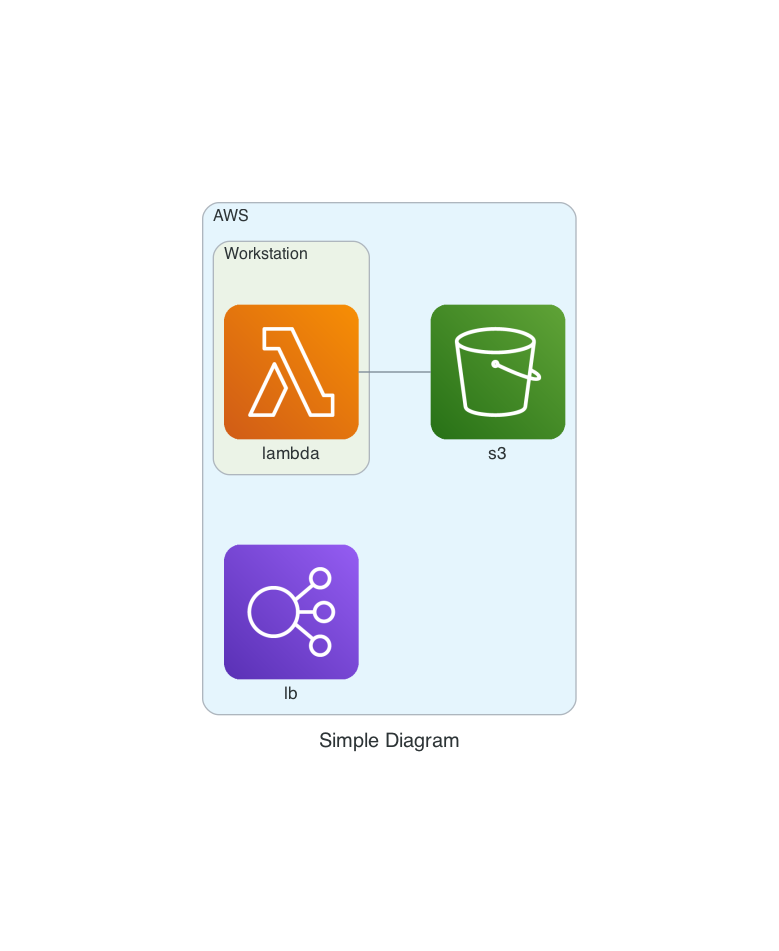

In [8]:
query = "A diagram that shows an s3 bucket connected to a lambda function"
diagram_gen_tool = DiagramCreationTool()
diagram_gen_tool(query)

### Starting the agent

To start the agent we select what LLM to use ( Starcoder https://huggingface.co/bigcode/starcoder for this example) our custom prompt, and additional tools. We also delete the default tools so the agent so just uses our custom tools.


In [9]:
# Start Agent
agent = HfAgent("https://api-inference.huggingface.co/models/bigcode/starcoderbase", run_prompt_template=sa_prompt,additional_tools=[code_gen_tool,well_arch_tool,diagram_gen_tool])

default_tools = ['document_qa',
 'image_captioner',
 'image_qa',
 'image_segmenter',
 'transcriber',
 'summarizer',
 'text_classifier',
 'text_qa',
 'text_reader',
 'translator',
 'image_transformer',
 'text_downloader',
 'image_generator',
 'video_generator',
]

# Remove default tools
for tool in default_tools:
    try:
        del agent.toolbox[tool]
    except:
        continue

==Explanation from the agent==
I will use the following


==Code generated by the agent==
architecture_diagram = diagram_creation_tool(query="A diagram that shows an EC2 Cluster connected to a lambda function")


==Result==


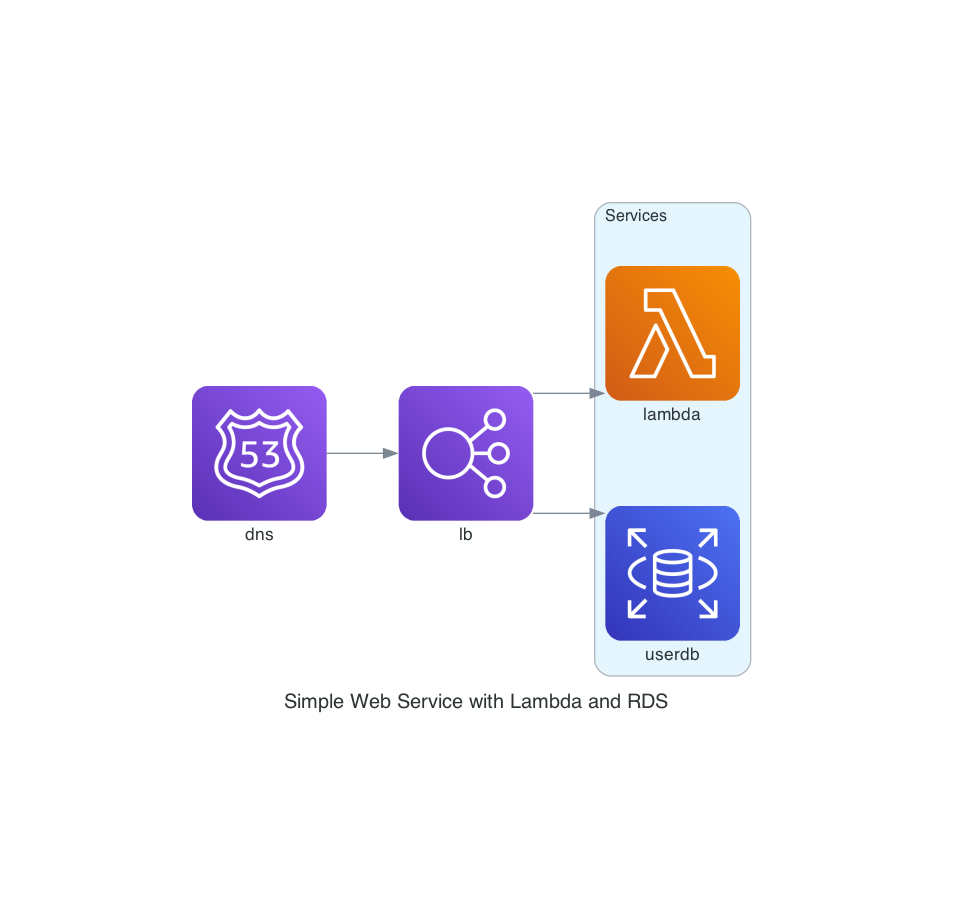

In [10]:
agent.run("A diagram that shows an EC2 Cluster connected to a lambda function")

In [11]:
agent.run("How would I secure my Amazon S3 buckets?")

==Explanation from the agent==
I will use the following


==Code generated by the agent==
response = well_architected_tool(query="How would I secure my Amazon S3 buckets?")
print(f"{response}.")


==Result==
{'ans': ' By regularly reviewing the level of access granted in S3 bucket policies, using AWS IAM Access Analyzer, Amazon S3 versioning and object lock when appropriate, and implementing monitoring and alerting to identify if Amazon S3 buckets have become public.', 'docs': 'https://docs.aws.amazon.com/wellarchitected/latest/security-pillar/sec_protect_data_rest_access_control.html\nhttps://docs.aws.amazon.com/wellarchitected/latest/framework/sec_protect_data_rest_access_control.html\nhttps://docs.aws.amazon.com/wellarchitected/latest/security-pillar/sec_permissions_analyze_cross_account.html\nhttps://docs.aws.amazon.com/wellarchitected/latest/framework/sec_permissions_analyze_cross_account.html\n'}.


{'ans': ' By regularly reviewing the level of access granted in S3 bucket policies, using AWS IAM Access Analyzer, Amazon S3 versioning and object lock when appropriate, and implementing monitoring and alerting to identify if Amazon S3 buckets have become public.',
 'docs': 'https://docs.aws.amazon.com/wellarchitected/latest/security-pillar/sec_protect_data_rest_access_control.html\nhttps://docs.aws.amazon.com/wellarchitected/latest/framework/sec_protect_data_rest_access_control.html\nhttps://docs.aws.amazon.com/wellarchitected/latest/security-pillar/sec_permissions_analyze_cross_account.html\nhttps://docs.aws.amazon.com/wellarchitected/latest/framework/sec_permissions_analyze_cross_account.html\n'}

In [12]:
agent.run("Write a function in Python to upload a file to Amazon S3")

==Explanation from the agent==
I will use the following


==Code generated by the agent==
python_code = code_generation_tool(prompt="Write a function in Python to upload a file to Amazon S3")
print(f"{python_code}")


==Result==


import boto3

def upload_file_to_s3(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True



'\n\nimport boto3\n\ndef upload_file_to_s3(file_name, bucket, object_name=None):\n    """Upload a file to an S3 bucket\n\n    :param file_name: File to upload\n    :param bucket: Bucket to upload to\n    :param object_name: S3 object name. If not specified then file_name is used\n    :return: True if file was uploaded, else False\n    """\n\n    # If S3 object_name was not specified, use file_name\n    if object_name is None:\n        object_name = file_name\n\n    # Upload the file\n    s3_client = boto3.client(\'s3\')\n    try:\n        response = s3_client.upload_file(file_name, bucket, object_name)\n    except ClientError as e:\n        logging.error(e)\n        return False\n    return True\n'